<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_20/S20_StableDiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git -C ERA_V1 pull

fatal: destination path 'ERA_V1' already exists and is not an empty directory.
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), 2.16 KiB | 245.00 KiB/s, done.
From https://github.com/jyanivaddi/ERA_V1
   e476b21..576b0da  master     -> origin/master
Updating e476b21..576b0da
Fast-forward
 session_20/S20_StableDiffusion.ipynb               | 138 ++++++++++++++++++---
 ...d_embeds_10.bin => learned_embeds_style_10.bin} | Bin
 session_20/learned_embeds_style_6.bin              | Bin 4864 -> 0 bytes
 ...ned_embeds_9.bin => learned_embeds_style_9.bin} | Bin
 4 files changed, 121 insertions(+), 17 deletions(-)
 rename session_20/{learned_embeds_10.bin => learned_embeds_style_10.bin} (100%)
 delete mode 100644 session_20/learned_embeds_style_6.bin
 rename session_20/{learned_embeds_9.bin => learned_embeds_style_9.bin} (1

In [27]:
import os
import sys
sys.path.append('/content/ERA_V1/session_20')

In [28]:
%pip install -qq -U datasets transformers pyarrow==9.0.0
%pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [29]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [30]:
from base64 import b64encode

import numpy as np
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel

from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
logging.set_verbosity_error()

torch_device = "cuda" if torch.cuda.is_available() else "cpu"


In [31]:
# Load the autoencoder
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder='vae')

# Load tokenizer and text encoder to tokenize and encode the text
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# Unet model for generating latents
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder='unet')

# Noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# Move everything to GPU
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

**Generate Clip embeddings for input text embeddings**

In [32]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

**Generate with input embeddings**

In [95]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def generate_with_embs(text_embeddings, random_seed):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(random_seed)   # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

**Create custom embeddings**

In [91]:
style_files = ['/content/ERA_V1/session_20/learned_embeds_style_0.bin',
               '/content/ERA_V1/session_20/learned_embeds_style_10.bin',
               '/content/ERA_V1/session_20/learned_embeds_style_2.bin',
               '/content/ERA_V1/session_20/learned_embeds_style_5.bin',
               '/content/ERA_V1/session_20/learned_embeds_style_8.bin']

def get_style_embeddings(style_file):
    style_embed = torch.load(style_file)
    style_name = list(style_embed.keys())[0]
    return style_embed[style_name]

def get_EOS_pos_in_prompt(prompt):
    return len(prompt.split())+1

**Get the custom embeddings**

In [96]:
def generate_image_with_custom_style(prompt, style_num=None, random_seed=41):
    eos_pos = get_EOS_pos_in_prompt(prompt)

    style_token_embedding = None
    if style_num:
        style_token_embedding = get_style_embeddings(style_files[style_num])

    # tokenize
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    input_ids = text_input.input_ids.to(torch_device)

    # get token embeddings
    token_emb_layer = text_encoder.text_model.embeddings.token_embedding
    token_embeddings = token_emb_layer(input_ids)

    # Append style token towards the end of the sentence embeddings
    if style_token_embedding is not None:
        token_embeddings[-1, eos_pos, :] = style_token_embedding

    # combine with pos embs
    pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
    position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
    position_embeddings = pos_emb_layer(position_ids)
    input_embeddings = token_embeddings + position_embeddings

    #  Feed through to get final output embs
    modified_output_embeddings = get_output_embeds(input_embeddings)

    # And generate an image with this:
    return generate_with_embs(modified_output_embeddings, random_seed)

In [87]:
def show_images(images_list):
    # Let's visualize the four channels of this latent representation:
    fig, axs = plt.subplots(1, len(images_list), figsize=(16, 4))
    for c in range(len(images_list)):
        axs[c].imshow(images_list[c])
    plt.show()

<ipython-input-95-f0c1dc4d65f2>:39: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

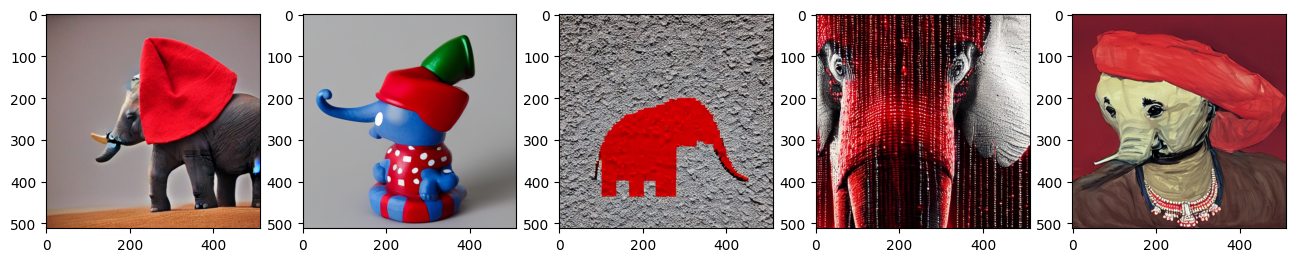

In [100]:
outputs = []
seed_values = [1,2,3,4,5]
prompt = "An elephant wearing a red hat"
num_styles = len(style_files)
for cnt in range(num_styles):
    outputs.append(generate_image_with_custom_style(prompt, cnt, seed_values[cnt]))
show_images(outputs)

